In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Hyperparameters
batch_size = 32
lr = 0.0002
epochs = 100
noise_dim = 100

In [4]:
# Dataset loading and transformation
transform = transforms.Compose([
    transforms.Resize(28),  # Ensure image size is 28x28
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

In [5]:
# Load MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.init_size = 7  # Initial size before upsampling (7x7 from 28x28 divided by 4)
        self.fc = nn.Linear(noise_dim, 128 * self.init_size ** 2)  # Output size: (128, 7, 7)

        self.block = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),  # Upsample to (64, 14, 14)
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),  # Upsample to (1, 28, 28)
            nn.Tanh()  # Output image in range [-1, 1]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten noise input into (batch_size, noise_dim)
        out = self.fc(x).view(x.size(0), 128, self.init_size, self.init_size)  # Reshape into (batch_size, 128, 7, 7)
        return self.block(out)

In [7]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # Input: (1, 28, 28), Output: (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # Input: (64, 14, 14), Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),  # Input: (128, 7, 7), Output: (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Input: (256, 4, 4), Output: (1, 1, 1)
            nn.Sigmoid()  # Output between [0, 1]
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

In [8]:
# Initialize models
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

In [9]:
# Optimizers
optim_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [10]:
# Loss function
criterion = nn.BCELoss()

In [11]:
# Training function
def train_GAN(generator, discriminator, data_loader, epochs):
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(data_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optim_D.zero_grad()
            real_outputs = discriminator(real_images)
            real_loss = criterion(real_outputs, real_labels)

            z = torch.randn(batch_size, noise_dim).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            D_loss = real_loss + fake_loss
            D_loss.backward()
            optim_D.step()

            # Train Generator
            optim_G.zero_grad()
            fake_outputs = discriminator(fake_images)
            G_loss = criterion(fake_outputs, real_labels)
            G_loss.backward()
            optim_G.step()

        print(f'Epoch [{epoch+1}/{epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}')

        if (epoch+1) % 10 == 0:
            visualize_comparison(real_images, fake_images)

In [12]:
# Function to display real and generated images side by side
def visualize_comparison(real_images, fake_images):
    real_images = (real_images + 1) / 2  # Rescale to [0, 1]
    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axs[0, i].imshow(real_images[i].squeeze().cpu().detach().numpy(), cmap='gray')  # Detach and convert to NumPy
        axs[0, i].set_title('Real')
        axs[0, i].axis('off')

        axs[1, i].imshow(fake_images[i].squeeze().cpu().detach().numpy(), cmap='gray')  # Detach and convert to NumPy
        axs[1, i].set_title('Fake')
        axs[1, i].axis('off')

    plt.show()

Epoch [1/100] | D Loss: 0.0622 | G Loss: 4.0271
Epoch [2/100] | D Loss: 0.1327 | G Loss: 4.2403
Epoch [3/100] | D Loss: 0.0907 | G Loss: 6.3267
Epoch [4/100] | D Loss: 0.0365 | G Loss: 3.6431
Epoch [5/100] | D Loss: 0.0152 | G Loss: 8.9696
Epoch [6/100] | D Loss: 0.0514 | G Loss: 5.7245
Epoch [7/100] | D Loss: 0.0065 | G Loss: 6.8010
Epoch [8/100] | D Loss: 0.0093 | G Loss: 6.3839
Epoch [9/100] | D Loss: 0.0066 | G Loss: 8.9218
Epoch [10/100] | D Loss: 0.0146 | G Loss: 8.9895


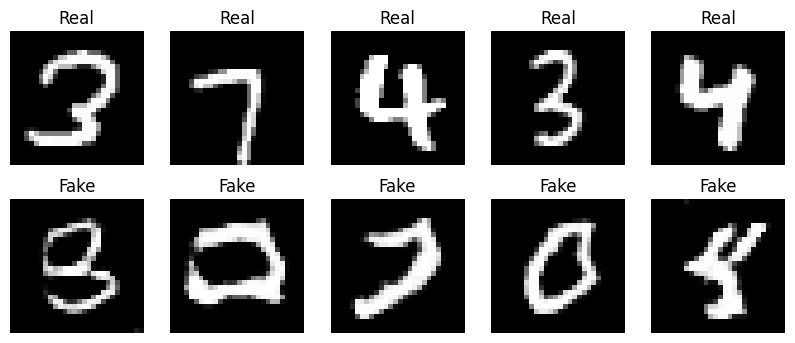

Epoch [11/100] | D Loss: 0.0580 | G Loss: 6.5664
Epoch [12/100] | D Loss: 0.0219 | G Loss: 5.7676
Epoch [13/100] | D Loss: 0.0671 | G Loss: 7.0467
Epoch [14/100] | D Loss: 0.0029 | G Loss: 6.1618
Epoch [15/100] | D Loss: 0.0098 | G Loss: 4.8838
Epoch [16/100] | D Loss: 0.0105 | G Loss: 9.1793
Epoch [17/100] | D Loss: 0.0006 | G Loss: 8.5517
Epoch [18/100] | D Loss: 0.0313 | G Loss: 5.3801
Epoch [19/100] | D Loss: 0.0014 | G Loss: 9.2954
Epoch [20/100] | D Loss: 0.0018 | G Loss: 8.5190


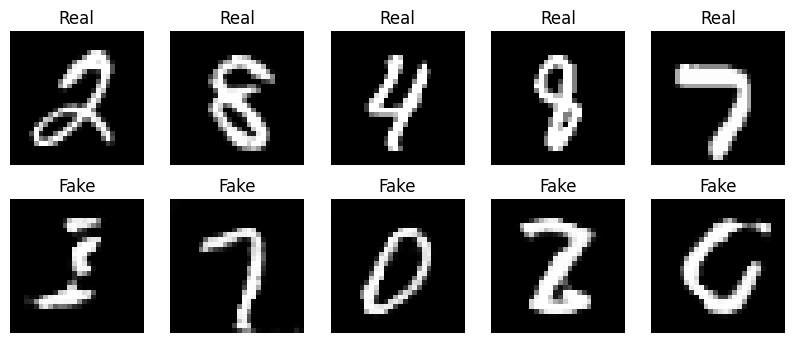

Epoch [21/100] | D Loss: 0.0027 | G Loss: 6.7544
Epoch [22/100] | D Loss: 0.0003 | G Loss: 10.1933
Epoch [23/100] | D Loss: 0.0007 | G Loss: 8.2856
Epoch [24/100] | D Loss: 0.0017 | G Loss: 9.8536
Epoch [25/100] | D Loss: 0.0027 | G Loss: 8.5785
Epoch [26/100] | D Loss: 0.7088 | G Loss: 1.1420
Epoch [27/100] | D Loss: 0.0273 | G Loss: 5.9966
Epoch [28/100] | D Loss: 0.0015 | G Loss: 7.9977
Epoch [29/100] | D Loss: 0.0074 | G Loss: 6.1754
Epoch [30/100] | D Loss: 0.0027 | G Loss: 9.6878


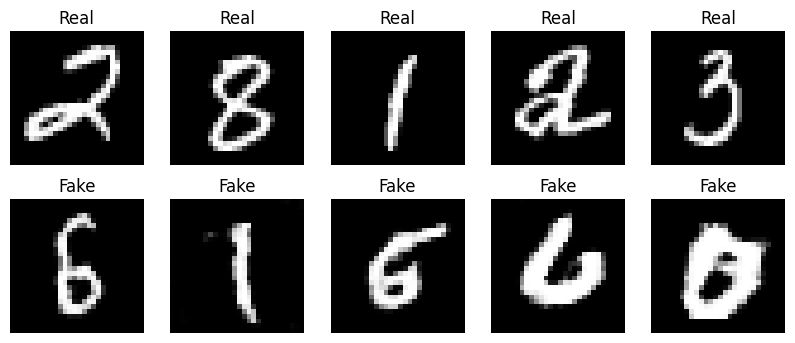

Epoch [31/100] | D Loss: 0.0067 | G Loss: 7.6945
Epoch [32/100] | D Loss: 0.0049 | G Loss: 8.5005
Epoch [33/100] | D Loss: 0.0062 | G Loss: 7.0942
Epoch [34/100] | D Loss: 0.0008 | G Loss: 9.1294
Epoch [35/100] | D Loss: 0.0007 | G Loss: 8.1545
Epoch [36/100] | D Loss: 0.0013 | G Loss: 9.2343
Epoch [37/100] | D Loss: 0.0084 | G Loss: 8.3422
Epoch [38/100] | D Loss: 0.0266 | G Loss: 9.9004
Epoch [39/100] | D Loss: 0.0021 | G Loss: 7.4152
Epoch [40/100] | D Loss: 0.0072 | G Loss: 6.9808


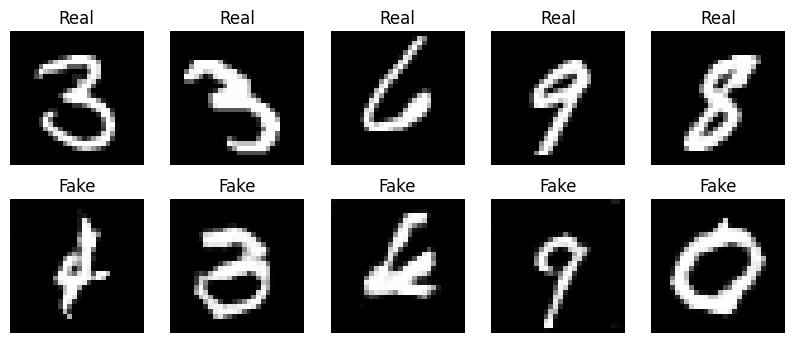

Epoch [41/100] | D Loss: 0.0099 | G Loss: 9.1543
Epoch [42/100] | D Loss: 0.0039 | G Loss: 7.8353
Epoch [43/100] | D Loss: 0.0106 | G Loss: 7.5529
Epoch [44/100] | D Loss: 0.0196 | G Loss: 10.5797
Epoch [45/100] | D Loss: 0.0003 | G Loss: 9.4539
Epoch [46/100] | D Loss: 0.0029 | G Loss: 9.4555
Epoch [47/100] | D Loss: 0.0011 | G Loss: 8.5256
Epoch [48/100] | D Loss: 0.0000 | G Loss: 14.3712
Epoch [49/100] | D Loss: 0.0035 | G Loss: 7.5409
Epoch [50/100] | D Loss: 0.0016 | G Loss: 7.9872


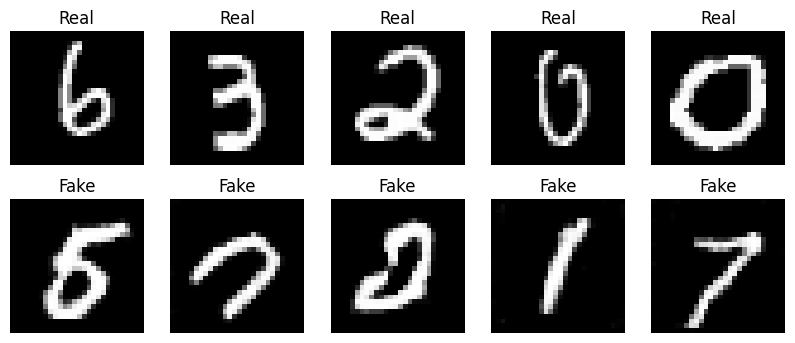

Epoch [51/100] | D Loss: 0.0003 | G Loss: 8.8825
Epoch [52/100] | D Loss: 0.0003 | G Loss: 9.9741
Epoch [53/100] | D Loss: 0.1071 | G Loss: 5.4641
Epoch [54/100] | D Loss: 0.0112 | G Loss: 12.3109
Epoch [55/100] | D Loss: 0.0010 | G Loss: 10.0682
Epoch [56/100] | D Loss: 0.0037 | G Loss: 11.0893
Epoch [57/100] | D Loss: 0.0056 | G Loss: 6.7201
Epoch [58/100] | D Loss: 0.0044 | G Loss: 7.2549
Epoch [59/100] | D Loss: 0.0200 | G Loss: 10.6079
Epoch [60/100] | D Loss: 0.0029 | G Loss: 11.7879


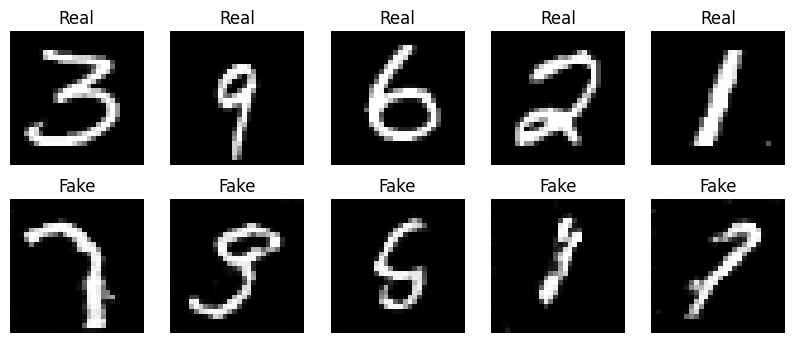

Epoch [61/100] | D Loss: 0.0199 | G Loss: 5.7357
Epoch [62/100] | D Loss: 0.0153 | G Loss: 12.2244
Epoch [63/100] | D Loss: 0.0003 | G Loss: 8.8655
Epoch [64/100] | D Loss: 0.0010 | G Loss: 9.1572
Epoch [65/100] | D Loss: 0.0052 | G Loss: 6.4325
Epoch [66/100] | D Loss: 0.0020 | G Loss: 9.6541
Epoch [67/100] | D Loss: 0.0177 | G Loss: 8.0015
Epoch [68/100] | D Loss: 0.0018 | G Loss: 7.5014
Epoch [69/100] | D Loss: 0.0002 | G Loss: 11.5474
Epoch [70/100] | D Loss: 0.3681 | G Loss: 2.1959


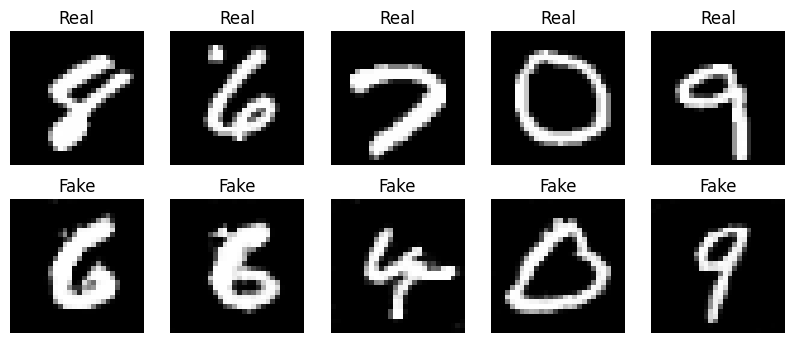

Epoch [71/100] | D Loss: 0.0009 | G Loss: 10.3717
Epoch [72/100] | D Loss: 0.0018 | G Loss: 13.0569
Epoch [73/100] | D Loss: 0.0896 | G Loss: 13.4008
Epoch [74/100] | D Loss: 0.0033 | G Loss: 7.1857
Epoch [75/100] | D Loss: 0.0005 | G Loss: 8.2954
Epoch [76/100] | D Loss: 0.0041 | G Loss: 7.7853
Epoch [77/100] | D Loss: 0.0006 | G Loss: 8.5160
Epoch [78/100] | D Loss: 0.0001 | G Loss: 9.9481
Epoch [79/100] | D Loss: 0.0005 | G Loss: 8.9176
Epoch [80/100] | D Loss: 0.0009 | G Loss: 11.9315


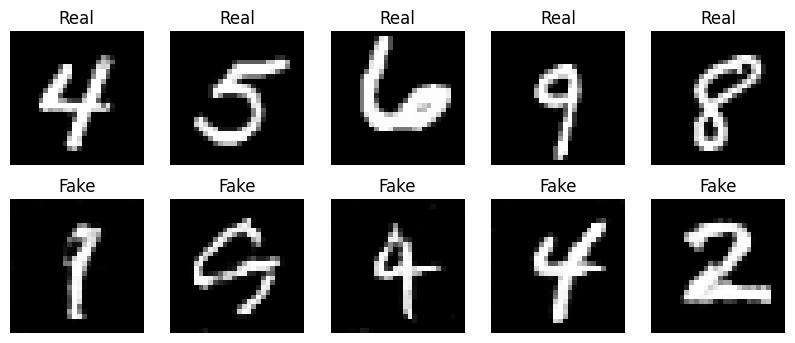

Epoch [81/100] | D Loss: 0.0001 | G Loss: 15.9926
Epoch [82/100] | D Loss: 0.0001 | G Loss: 10.8947
Epoch [83/100] | D Loss: 0.0003 | G Loss: 10.5686
Epoch [84/100] | D Loss: 0.0002 | G Loss: 12.9905
Epoch [85/100] | D Loss: 0.0024 | G Loss: 7.4458
Epoch [86/100] | D Loss: 0.0003 | G Loss: 10.2904
Epoch [87/100] | D Loss: 0.0011 | G Loss: 10.9880
Epoch [88/100] | D Loss: 0.0021 | G Loss: 7.5873
Epoch [89/100] | D Loss: 0.0033 | G Loss: 6.8378
Epoch [90/100] | D Loss: 0.0110 | G Loss: 6.7027


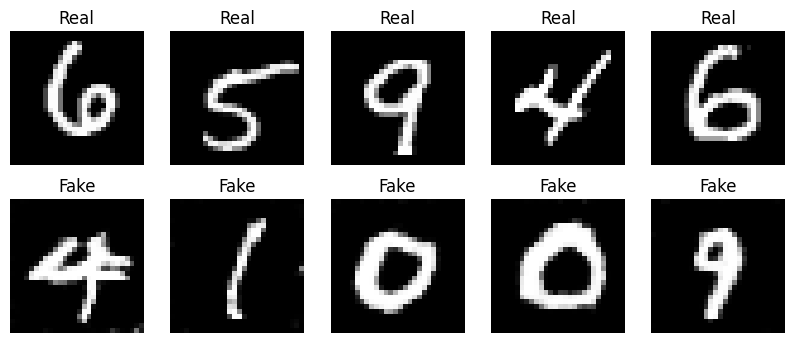

Epoch [91/100] | D Loss: 0.0001 | G Loss: 12.9258
Epoch [92/100] | D Loss: 0.0008 | G Loss: 8.5922
Epoch [93/100] | D Loss: 0.0001 | G Loss: 11.1084
Epoch [94/100] | D Loss: 0.0140 | G Loss: 6.0147
Epoch [95/100] | D Loss: 0.0239 | G Loss: 10.6354
Epoch [96/100] | D Loss: 0.0002 | G Loss: 10.4989
Epoch [97/100] | D Loss: 0.0382 | G Loss: 6.3091
Epoch [98/100] | D Loss: 0.0002 | G Loss: 9.5452
Epoch [99/100] | D Loss: 0.0001 | G Loss: 11.2629
Epoch [100/100] | D Loss: 0.0012 | G Loss: 7.6047


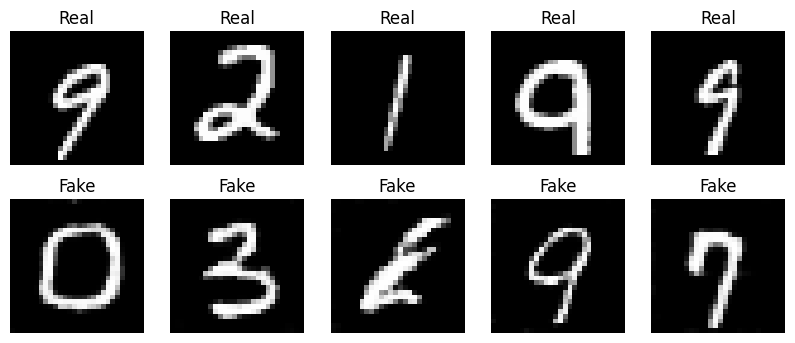

In [13]:
# Train and visualize results
train_GAN(generator, discriminator, data_loader, epochs)